# Optimización de Parámetros - XGB

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from modulos.LR.gruas.generals import make_lags
from modulos.DirRec.gruas.optimizer import XGBOptimizer

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,Periodo,idArticulo,ventas,DescProducto
0,2021-10-01,9950,74.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
1,2021-09-01,9950,25.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
2,2021-08-01,9950,28.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
3,2021-07-01,9950,15.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
4,2021-06-01,9950,13.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,551,594,963,1208,1224,1627,3090,3745,3882,3883,...,20263,20301,20305,20310,20697,20769,21577,23900,26158,27165
Periodo,,,,,,,,,,,,,,,,,,,,,
2021-06-01,4.0,3.0,6.0,140.0,0.0,5.0,4.0,5.0,2.0,0.0,...,4.0,6.0,0.0,2.0,2.0,0.0,6.0,104.0,42.0,11.0
2021-07-01,2.0,1.0,14.0,166.0,10.0,17.0,2.0,0.0,1.0,3.0,...,8.0,9.0,4.0,6.0,1.0,3.0,15.0,40.0,17.0,42.0
2021-08-01,8.0,4.0,2.0,520.0,7.0,4.0,11.0,2.0,0.0,4.0,...,48.0,5.0,7.0,7.0,5.0,2.0,33.0,228.0,38.0,12.0
2021-09-01,3.0,10.0,4.0,280.0,2.0,9.0,11.0,8.0,1.0,1.0,...,8.0,8.0,5.0,0.0,10.0,2.0,10.0,84.0,14.0,19.0
2021-10-01,3.0,4.0,3.0,510.0,4.0,3.0,4.0,5.0,0.0,9.0,...,12.0,15.0,25.0,13.0,5.0,3.0,4.0,316.0,9.0,19.0


## Optimizando un solo Producto

## Baseline XGB

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from modulos.LR.gruas.generals import cross_validation_ts_mape_r2, split_data_train, make_timeserie

idArticulo = 594
ts = df_time[idArticulo].copy()
n_lags = 4
X,y, scaler  = make_timeserie(ts, n_lags)

In [9]:
model = XGBRegressor(max_depth=6, gamma=.01, n_estimators=2,)
model.fit(X, y)
y_fit = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [10]:
from modulos.LR.gruas.generals import cross_validation_ts_mape_r2, split_data_train, make_timeserie
X_train, y_train = split_data_train(X, y, .2)
mape, r2_ = cross_validation_ts_mape_r2(model, X, y , .2)
print(f"MAPE: {mape}")
print(f"R2: {r2_}")
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

MAPE: 1.5171472514997855
R2: 0.0011706846354847533


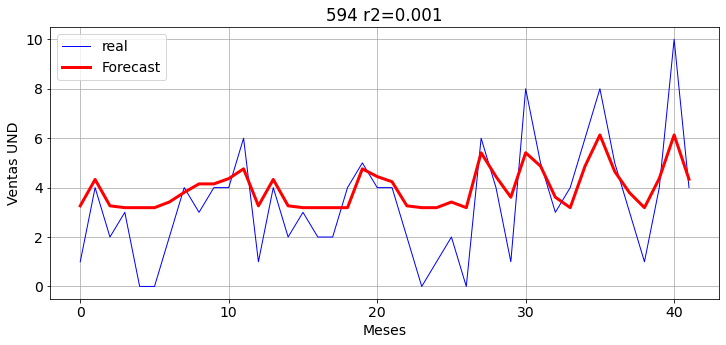

In [11]:
show_results_r2(scaler.inverse_transform(y), scaler.inverse_transform(y_fit),idArticulo, r2_ )


# Optimizar todos los Productos        
        

In [12]:
optimizer = XGBOptimizer(df_time, iterations=200, data_path= DATA_PATH , model='XGB', subpath = 'DirRec')
optimizer.run( chunk_size=2)

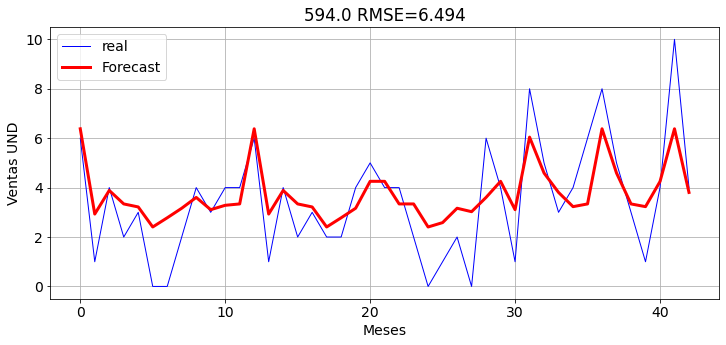

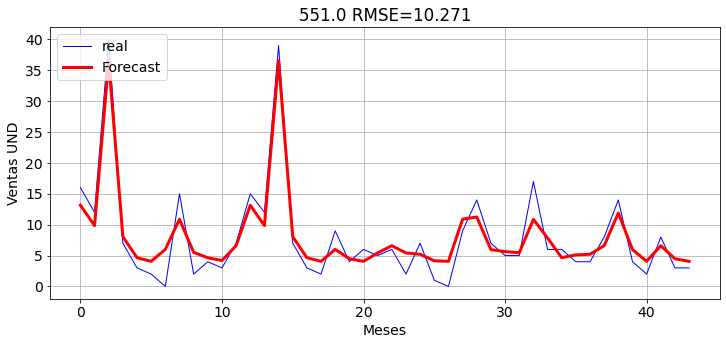

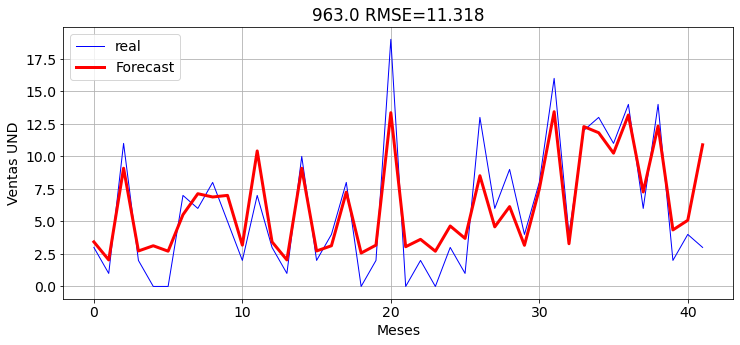

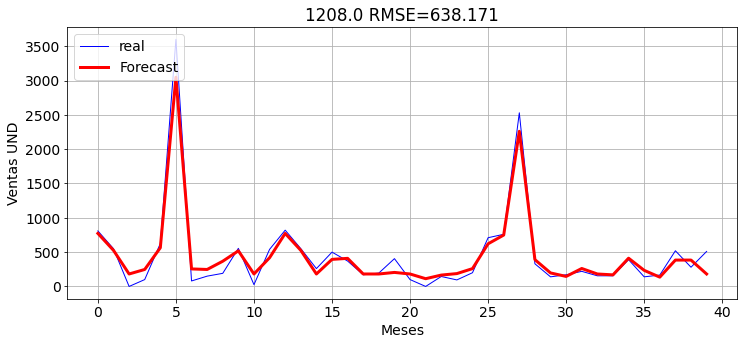

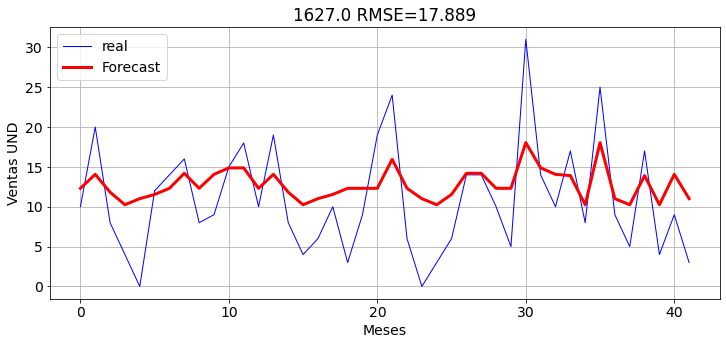

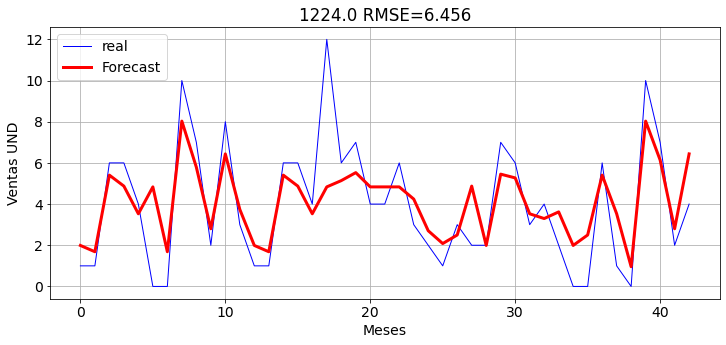

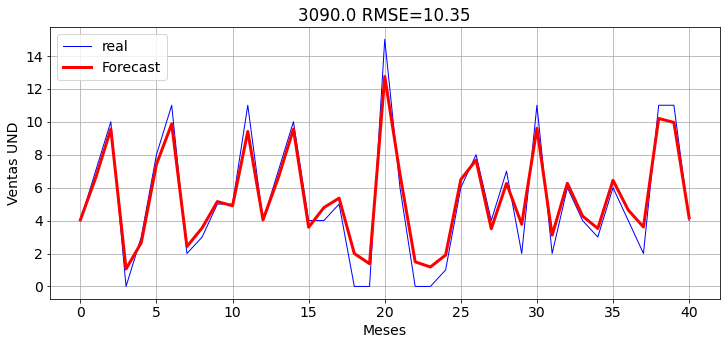

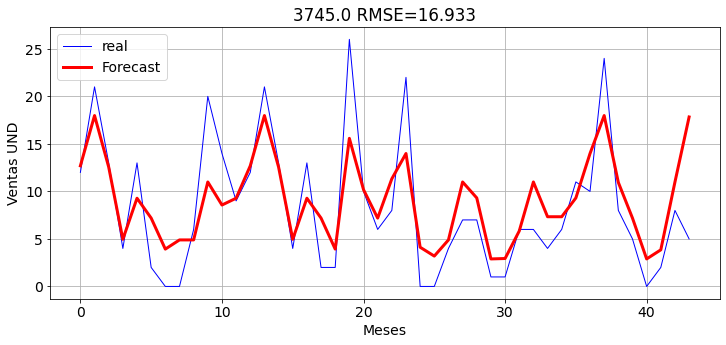

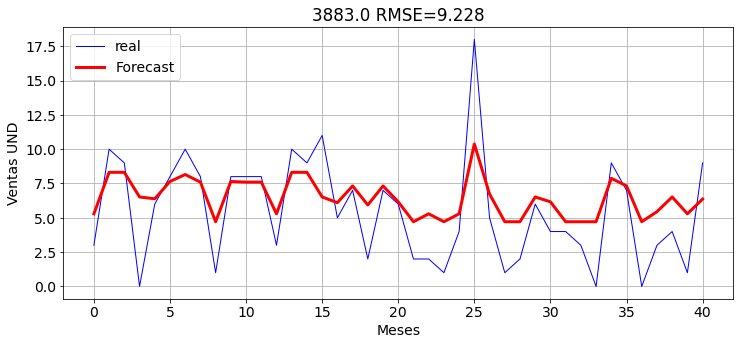

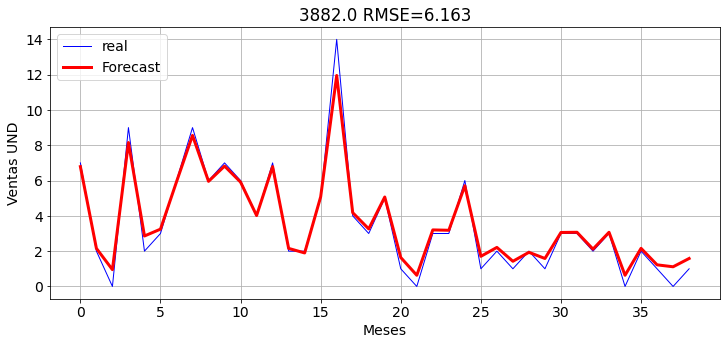

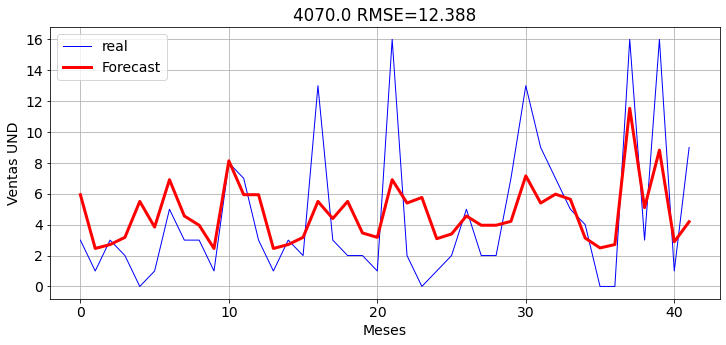

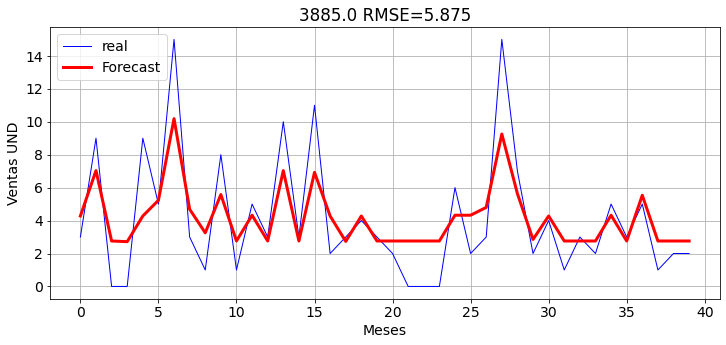

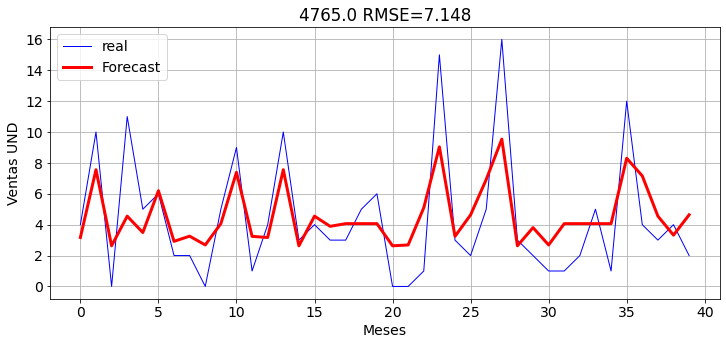

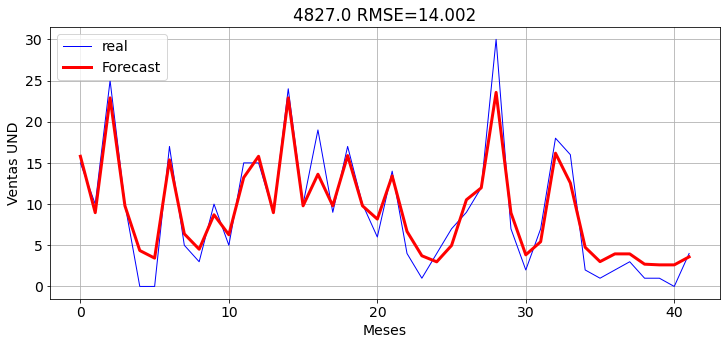

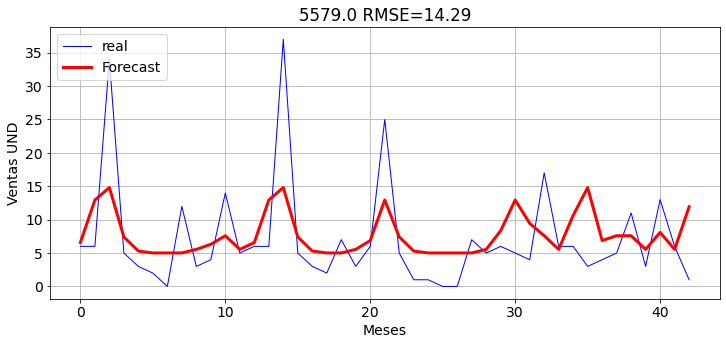

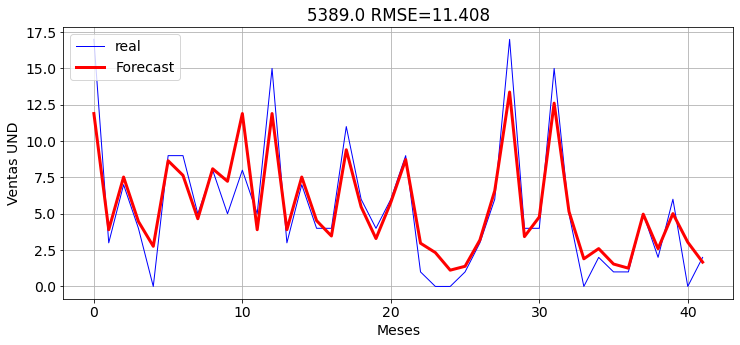

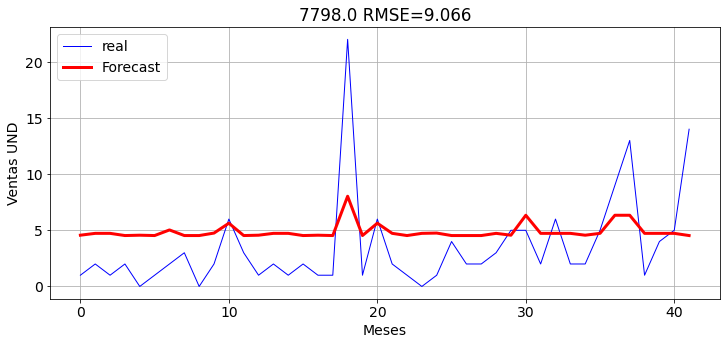

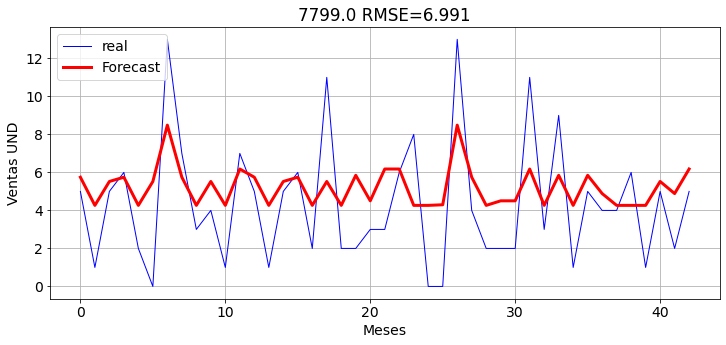

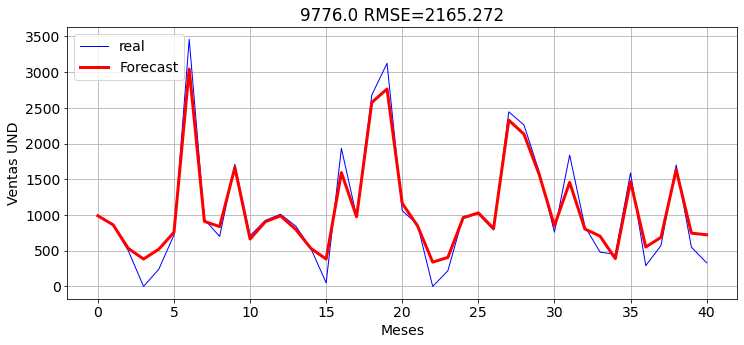

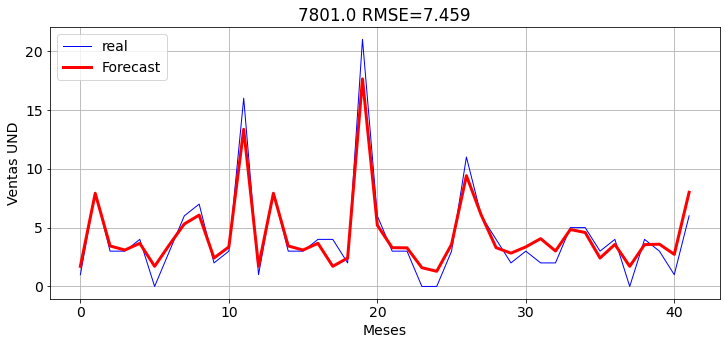

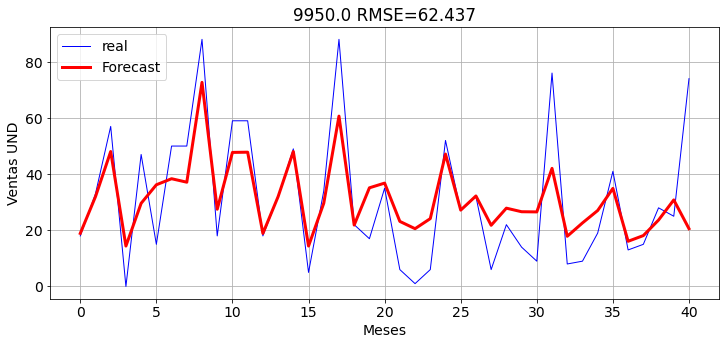

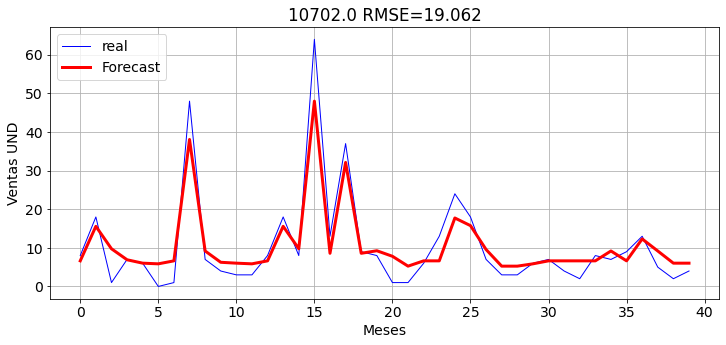

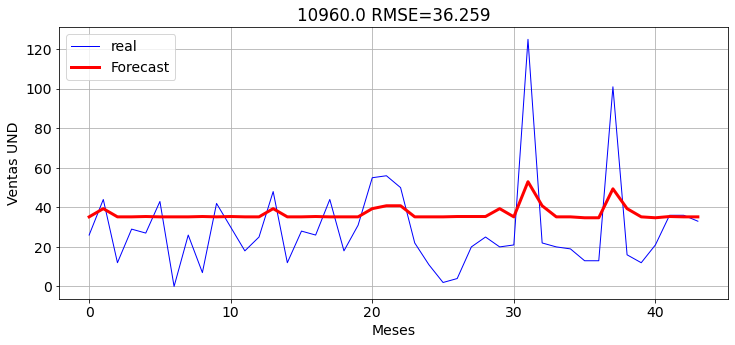

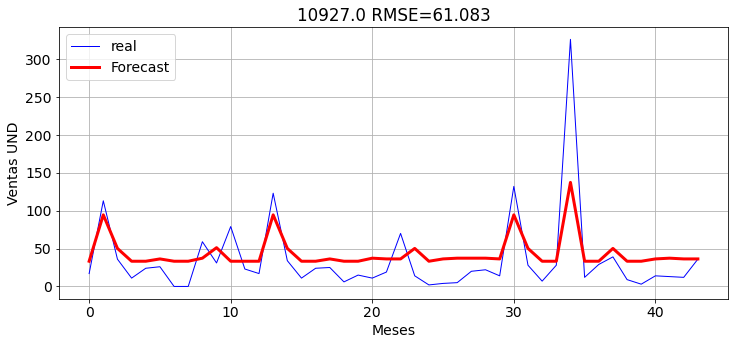

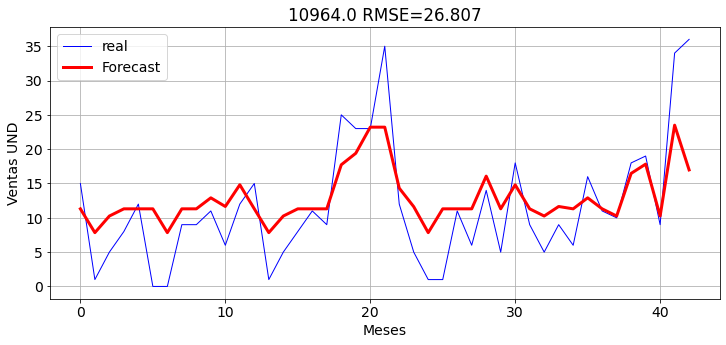

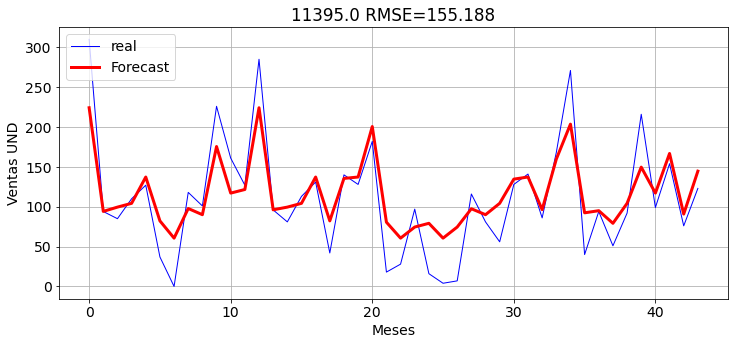

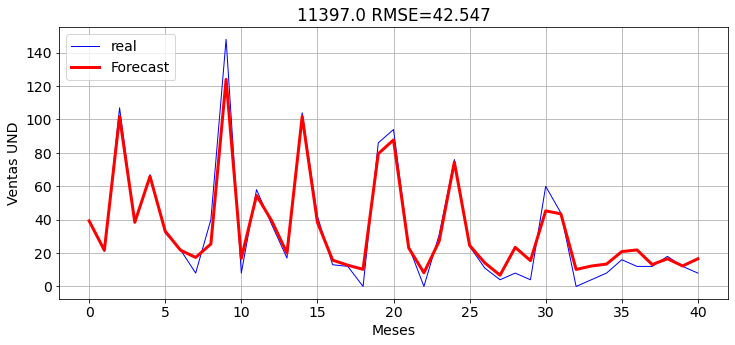

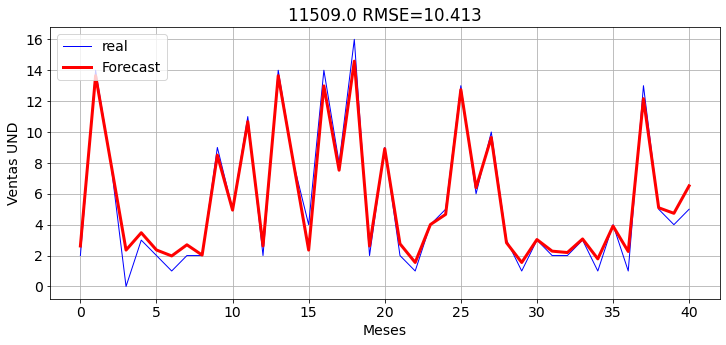

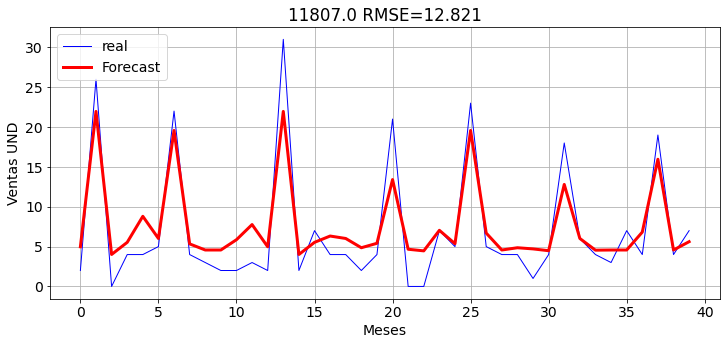

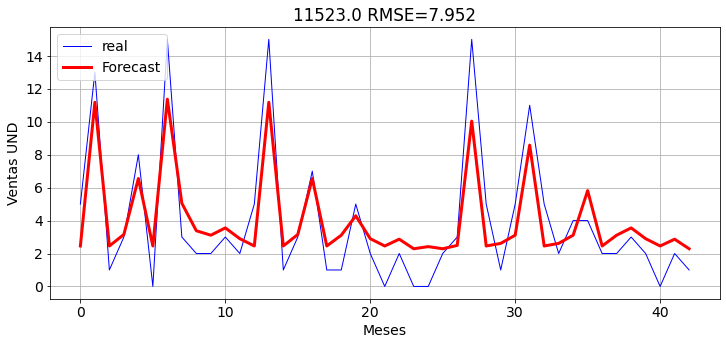

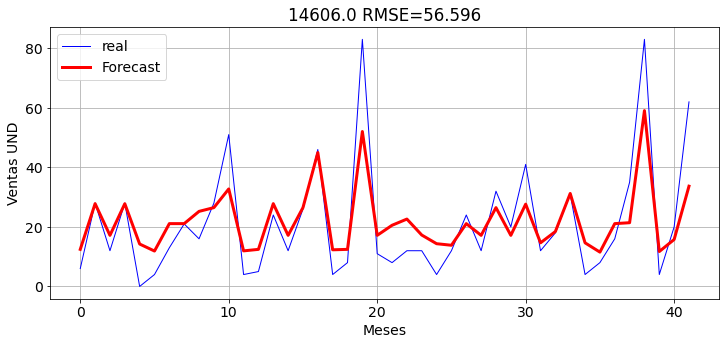

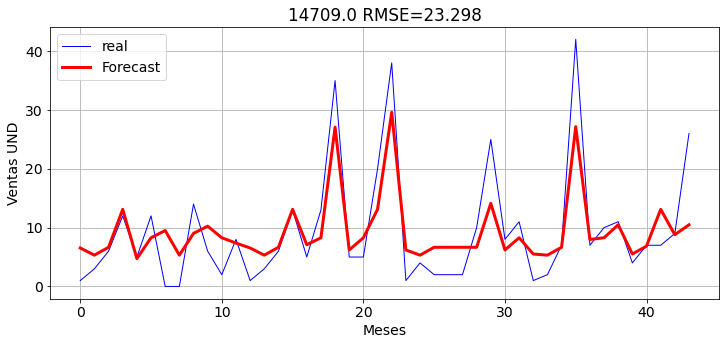

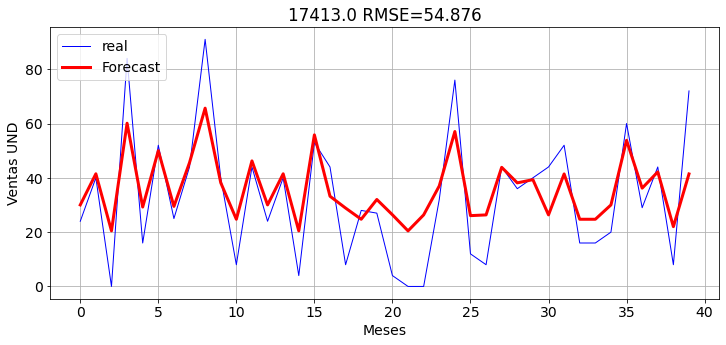

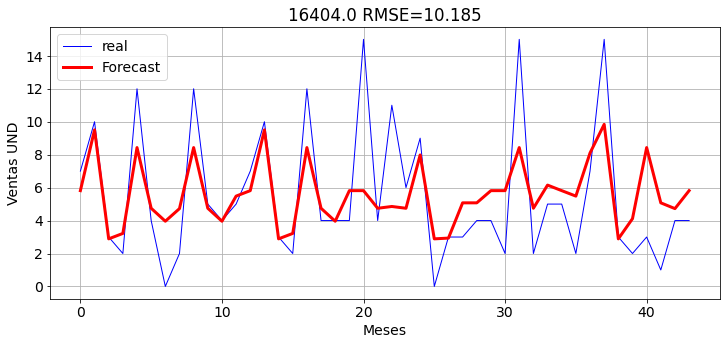

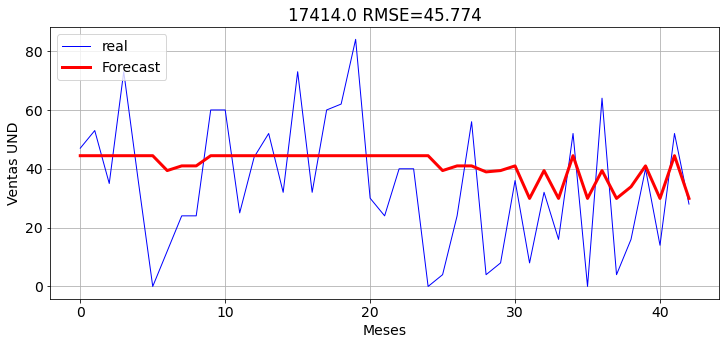

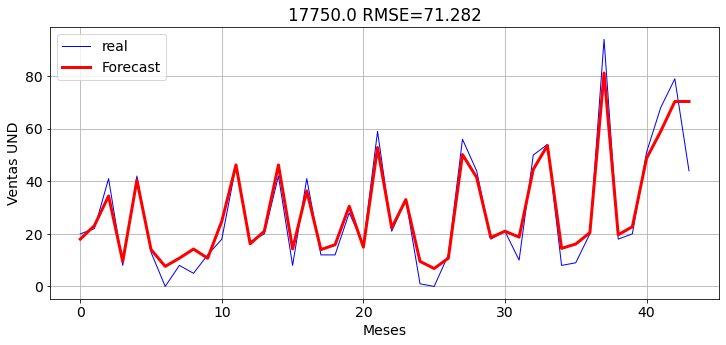

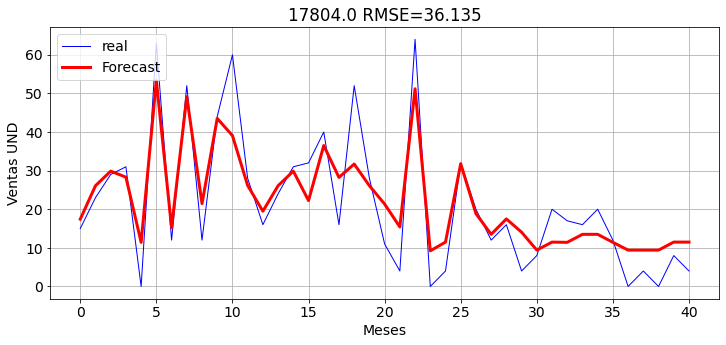

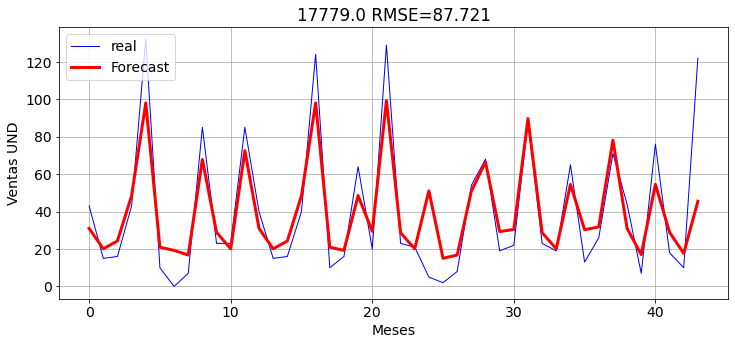

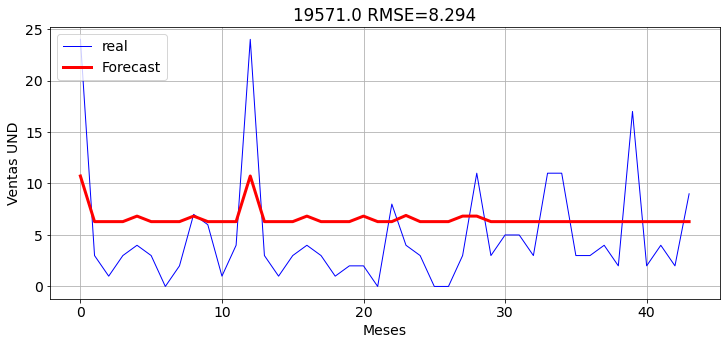

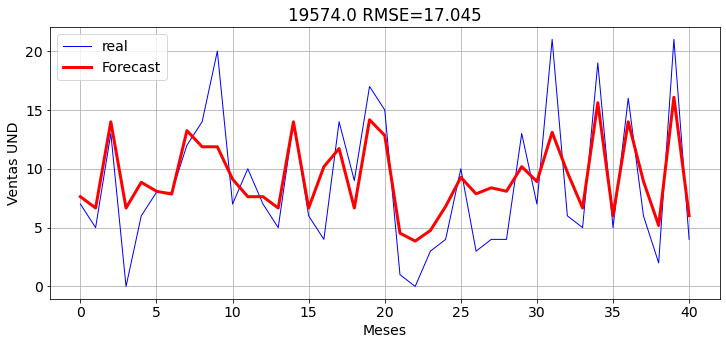

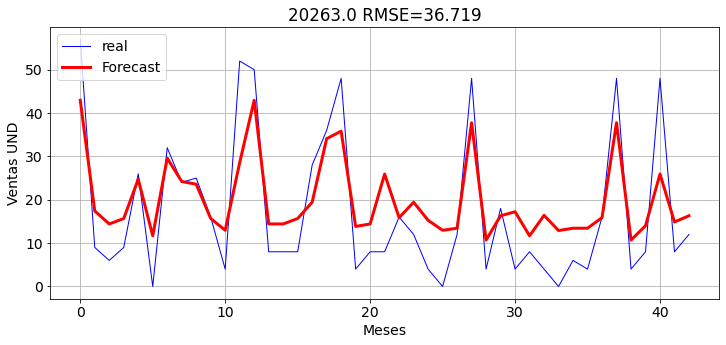

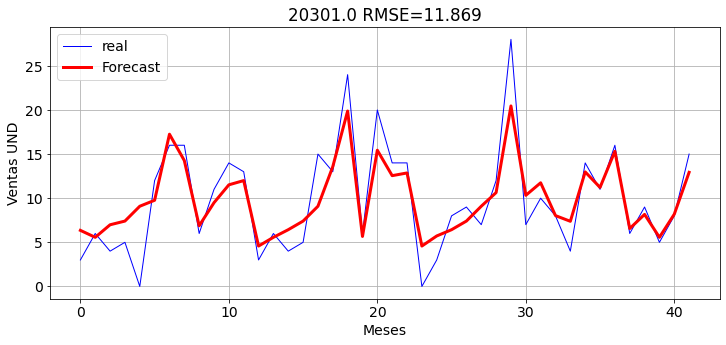

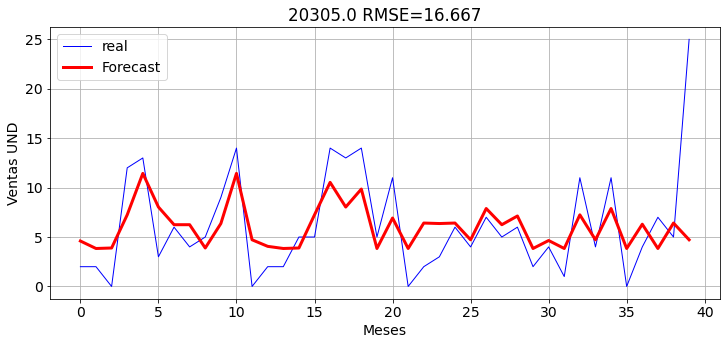

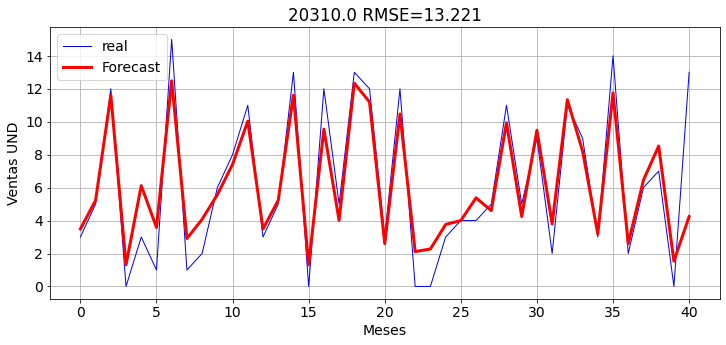

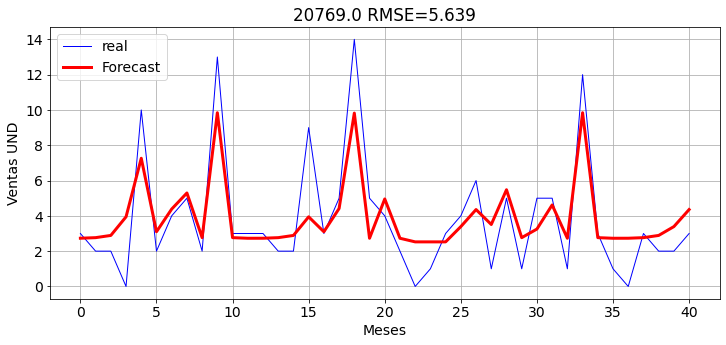

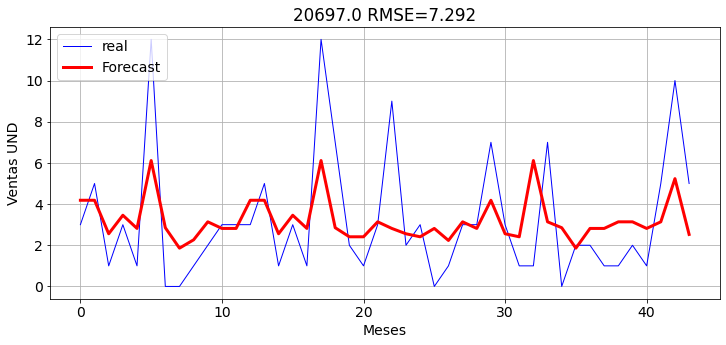

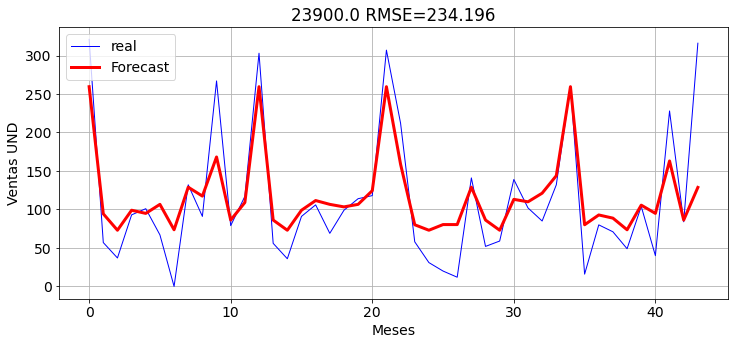

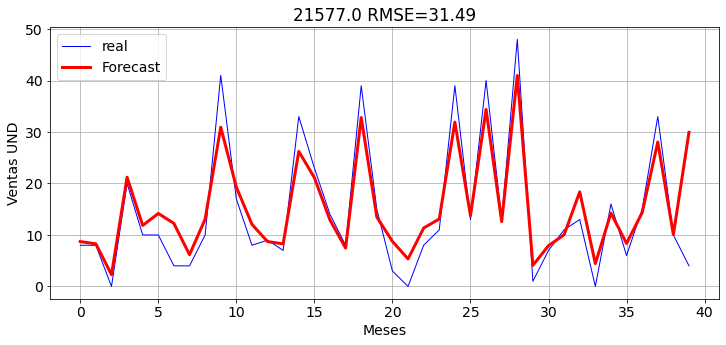

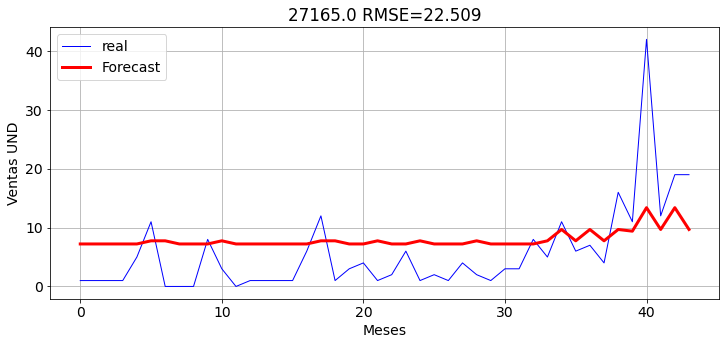

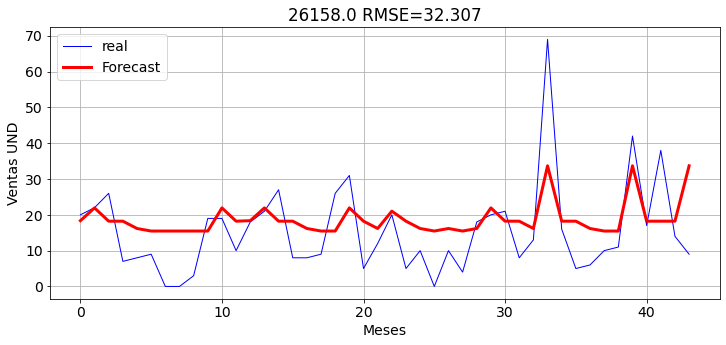

In [13]:
optimizer.print_results()

# Optimizer -  Evolution on time

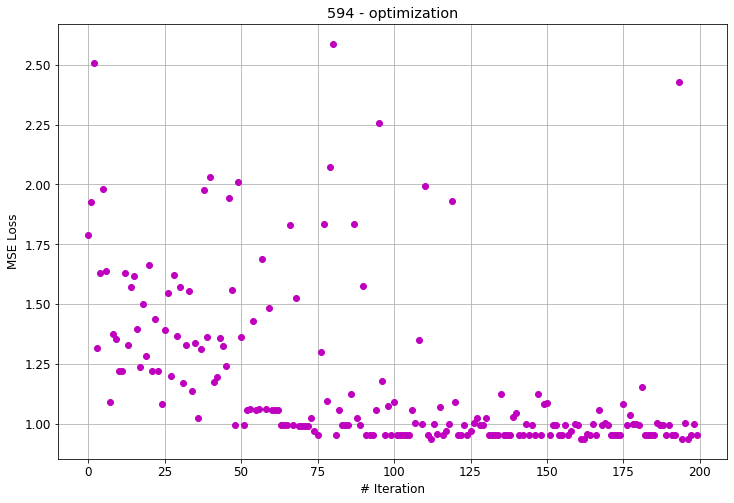

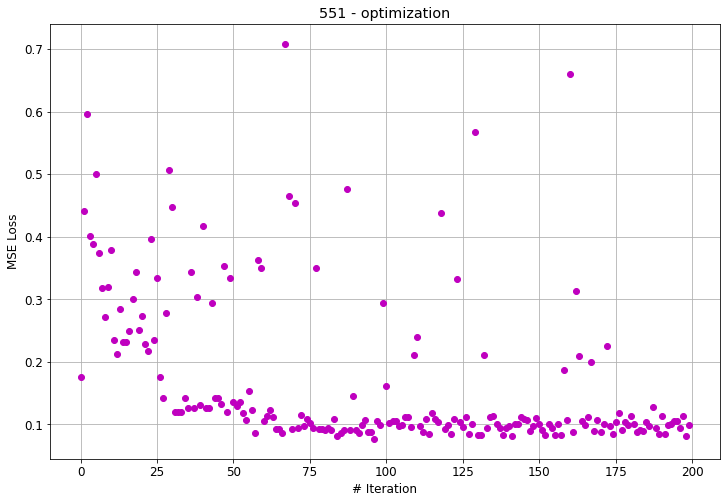

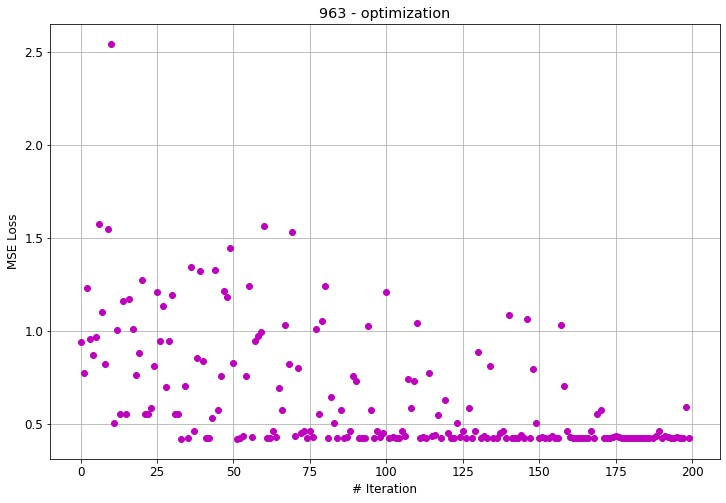

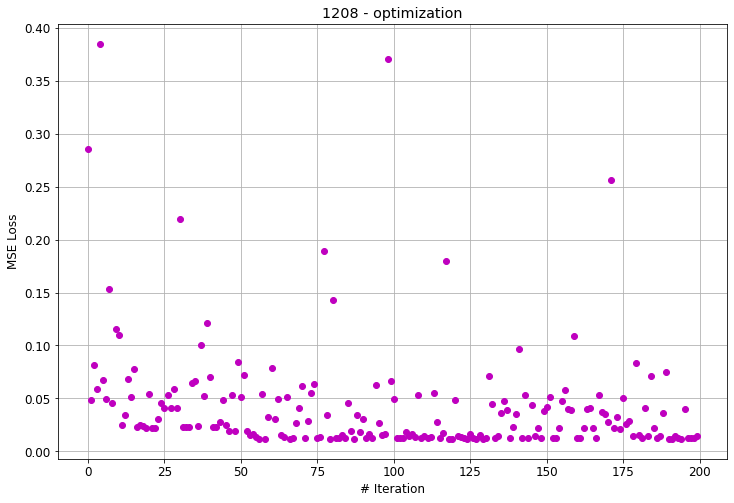

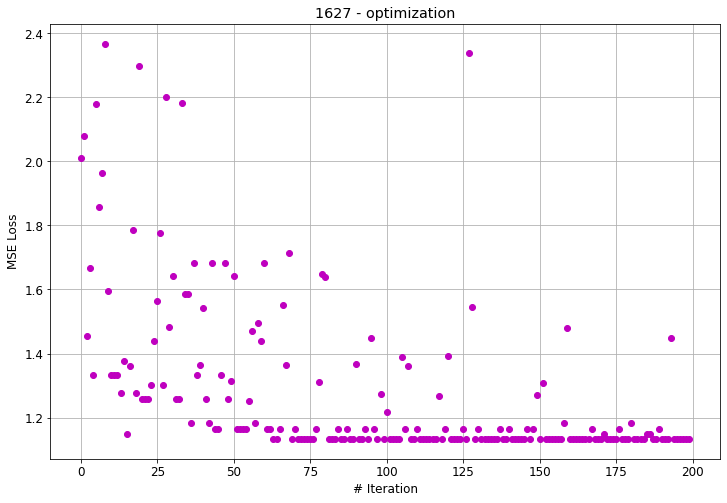

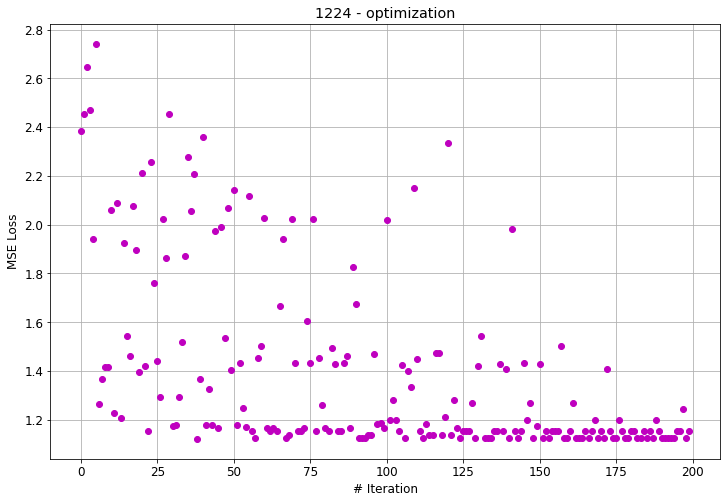

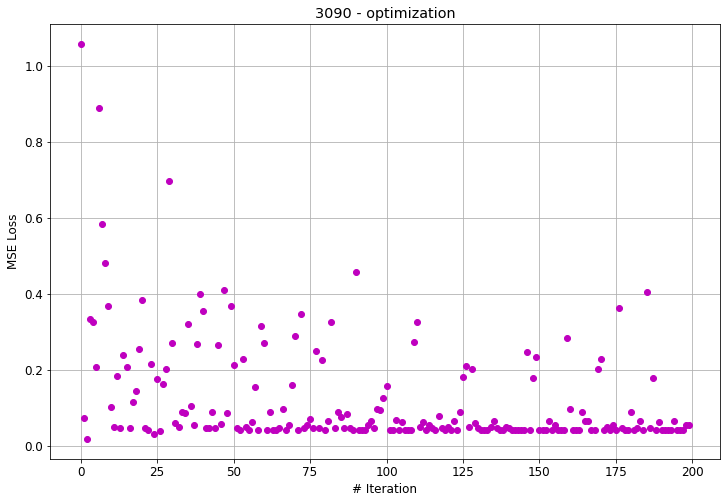

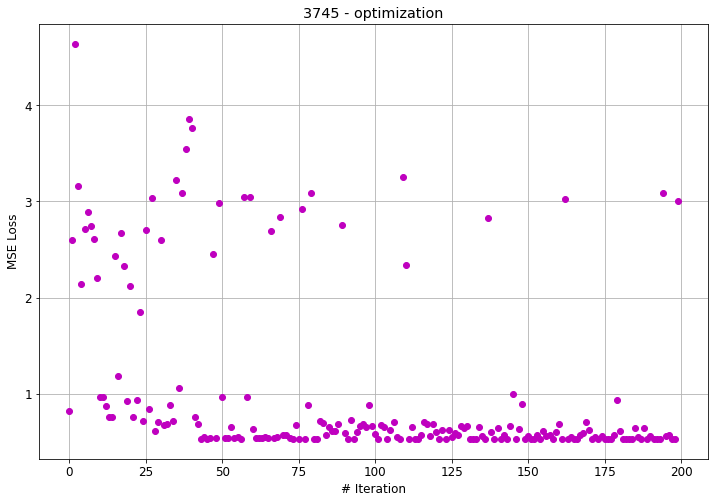

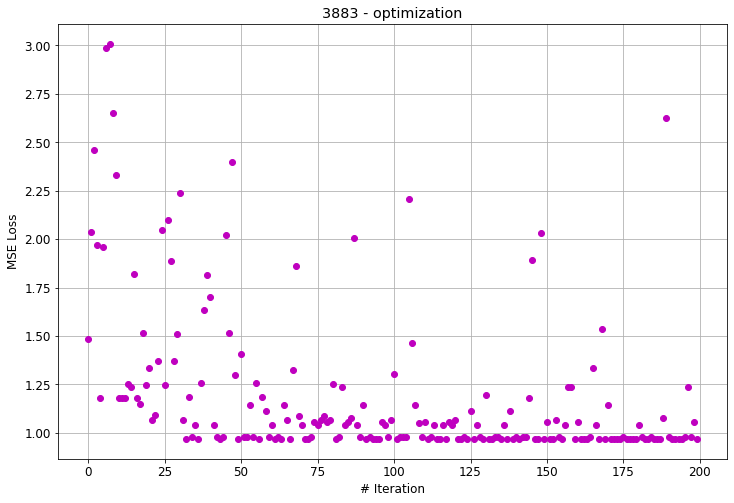

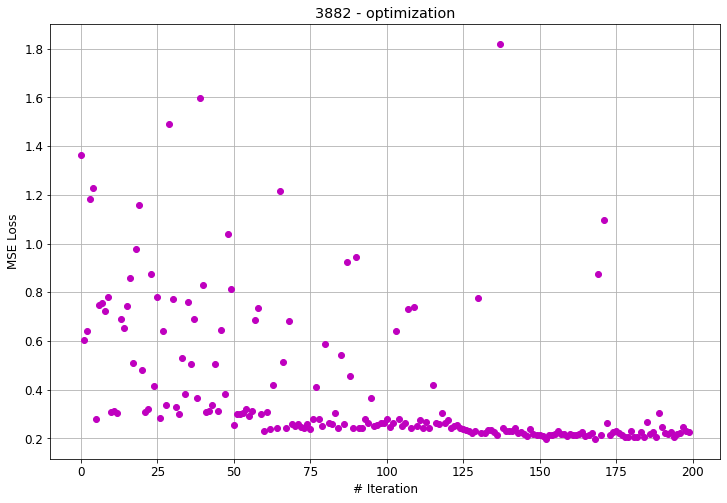

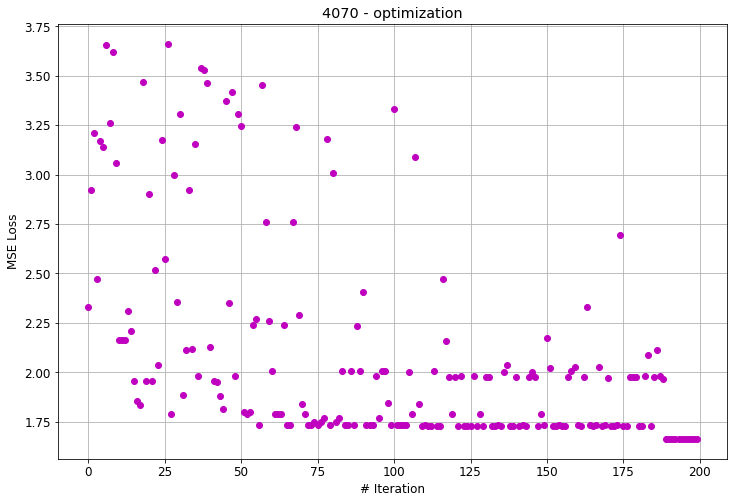

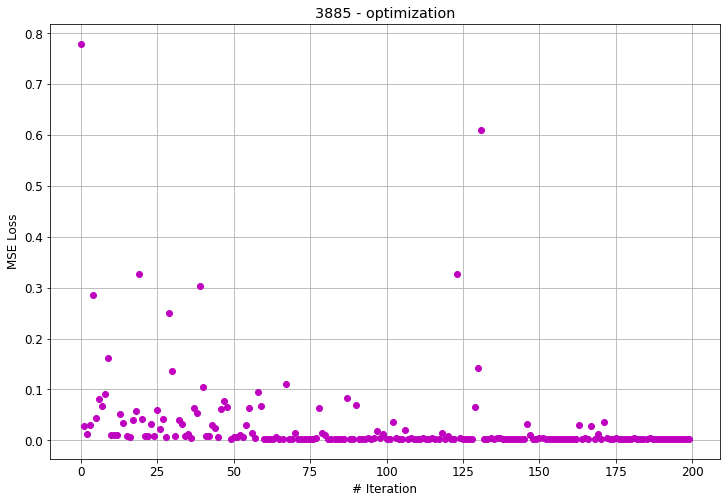

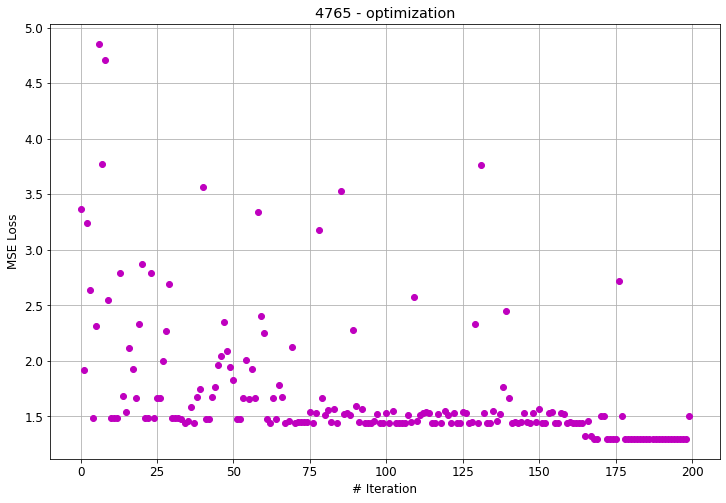

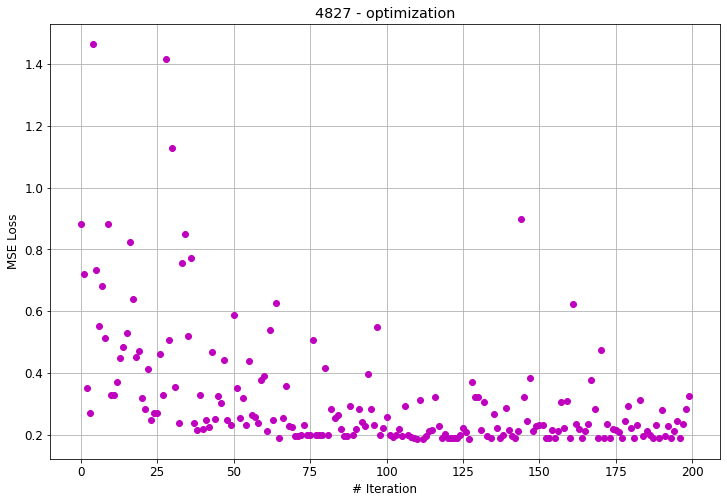

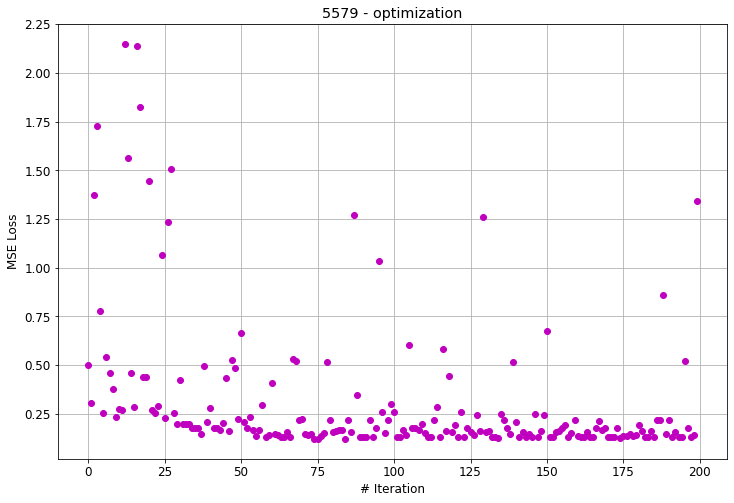

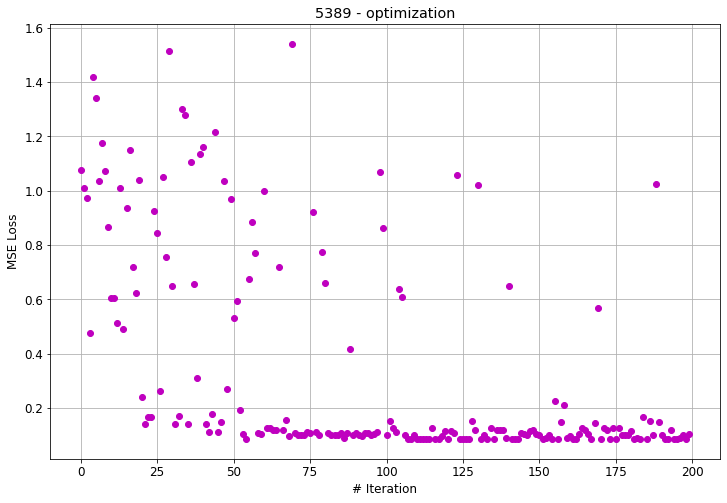

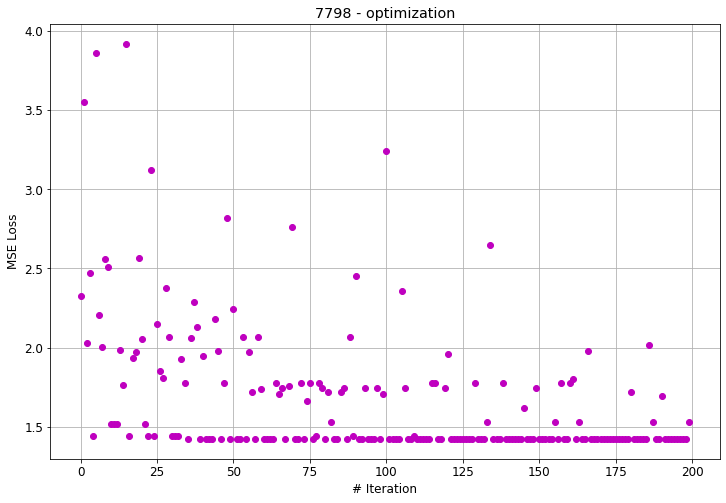

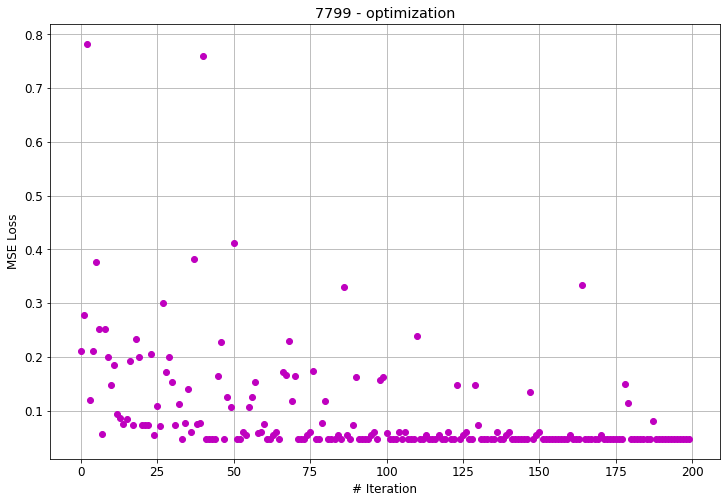

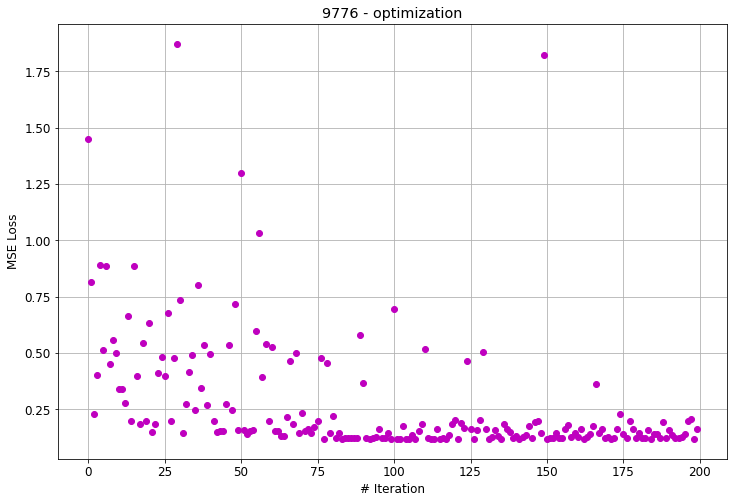

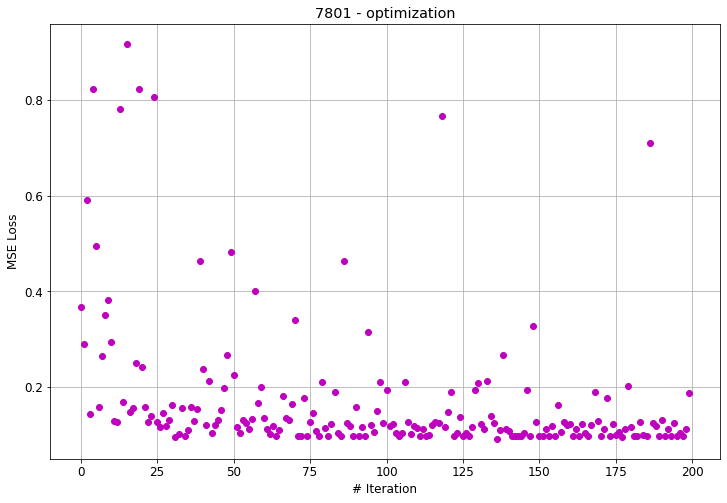

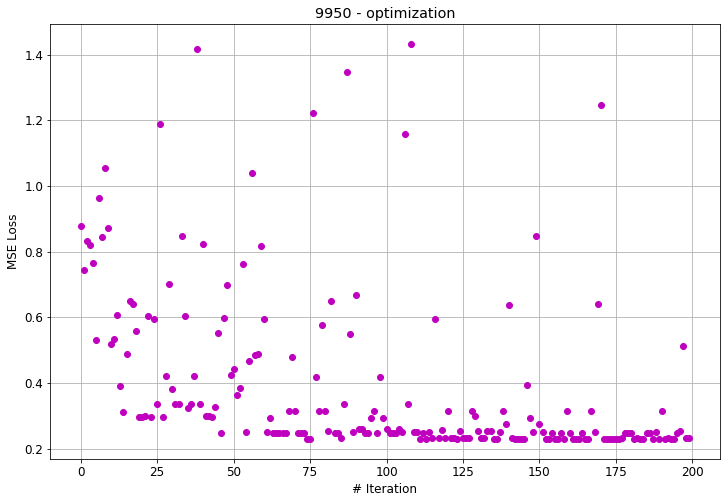

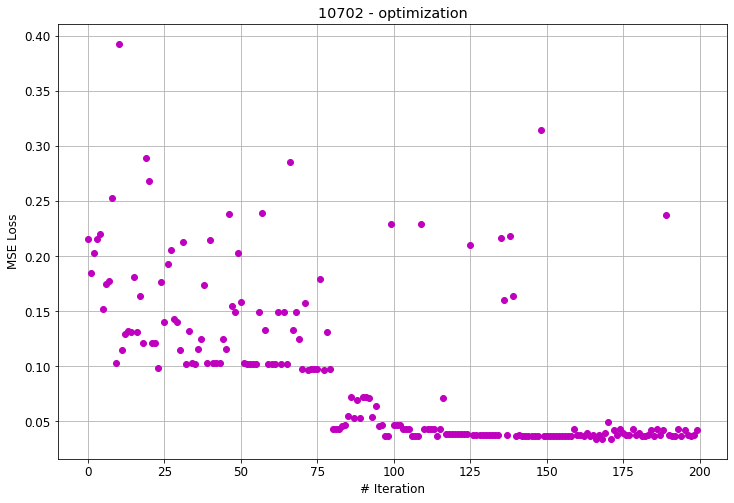

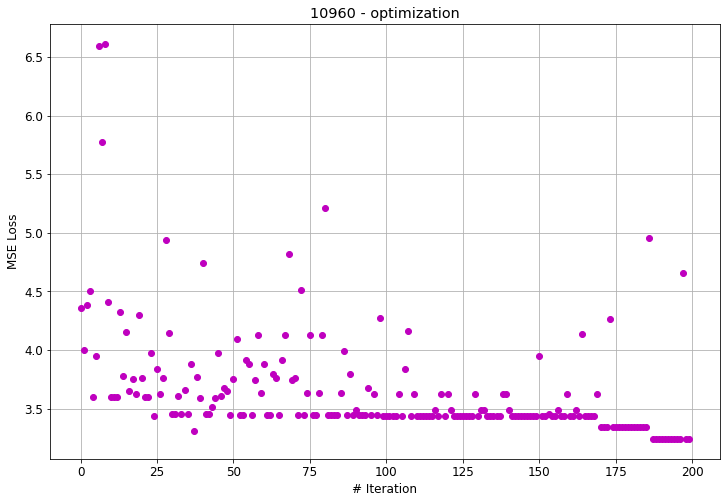

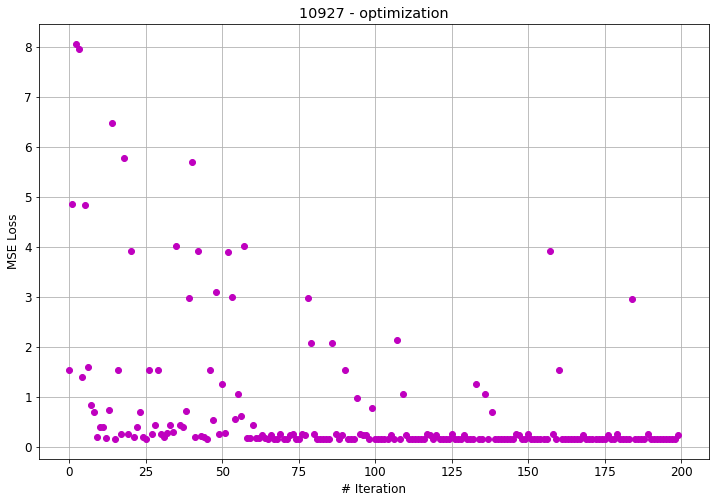

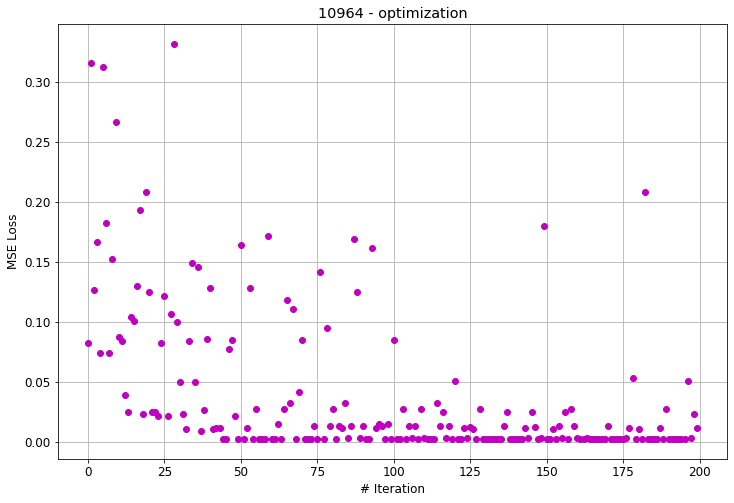

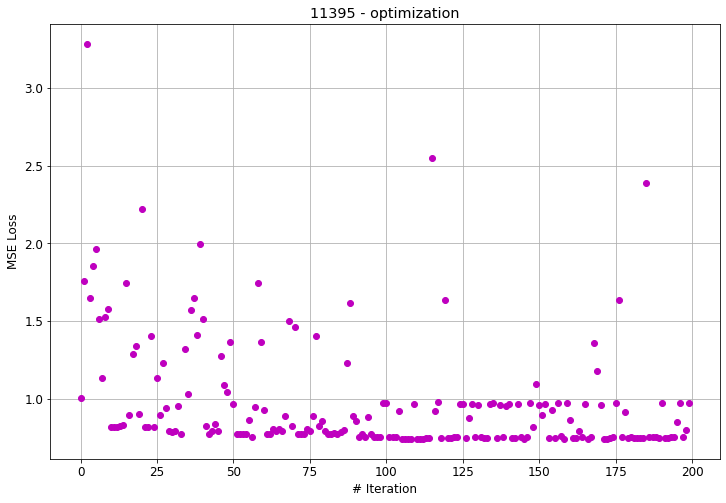

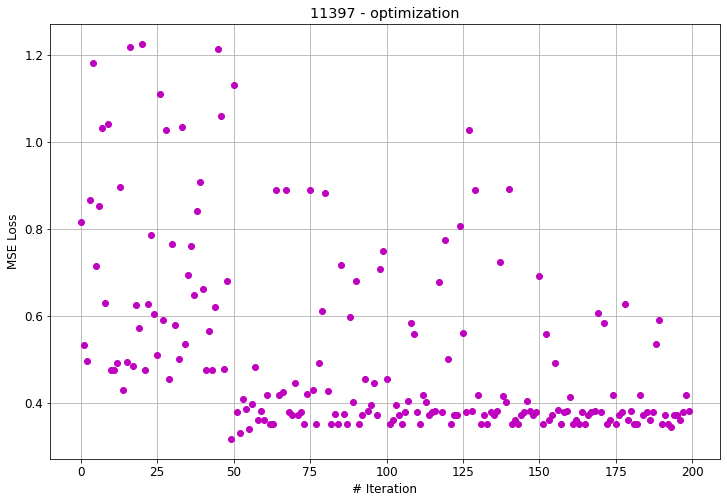

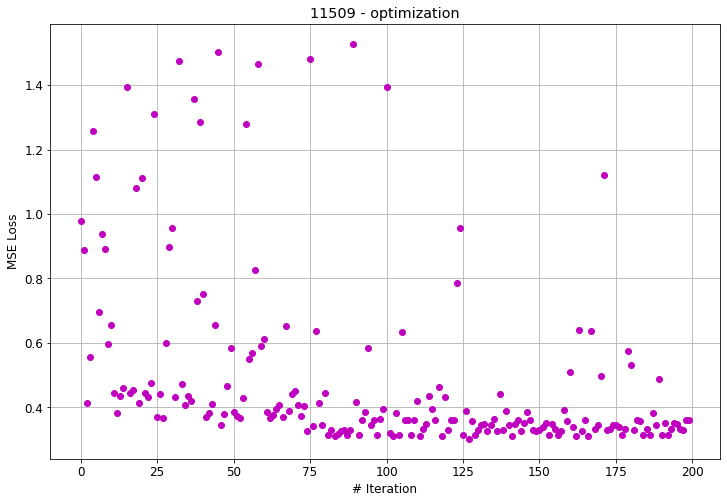

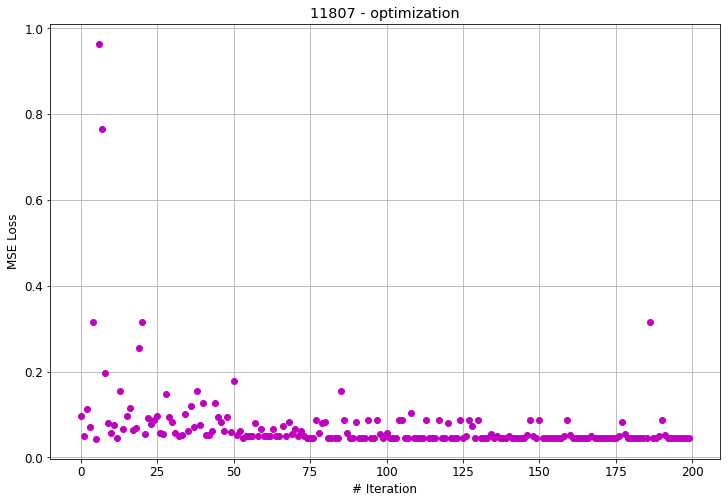

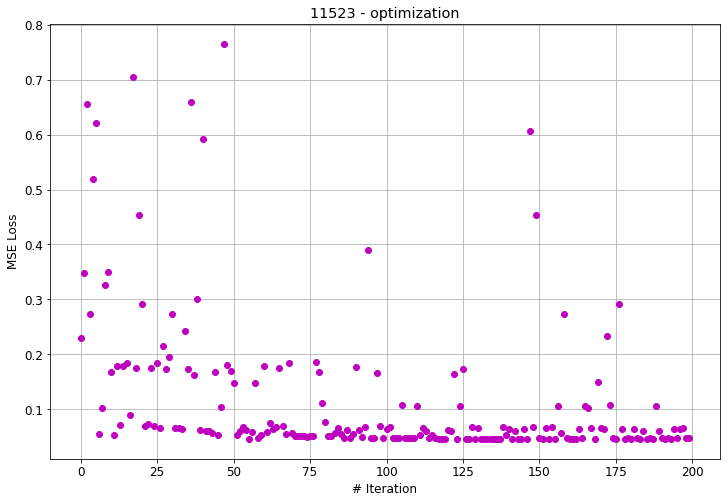

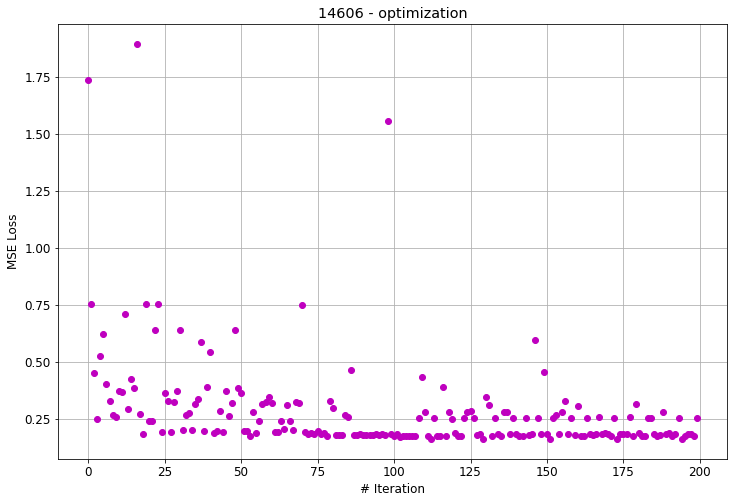

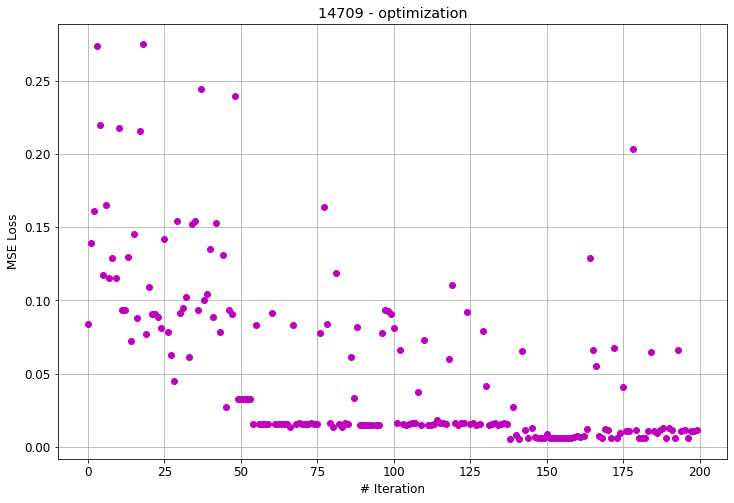

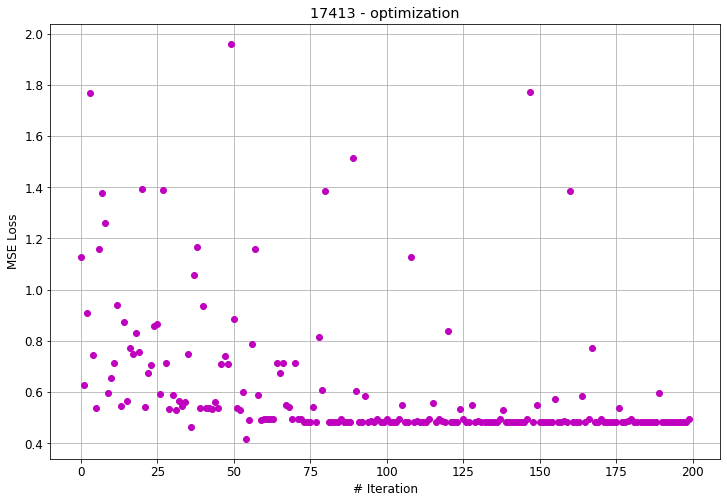

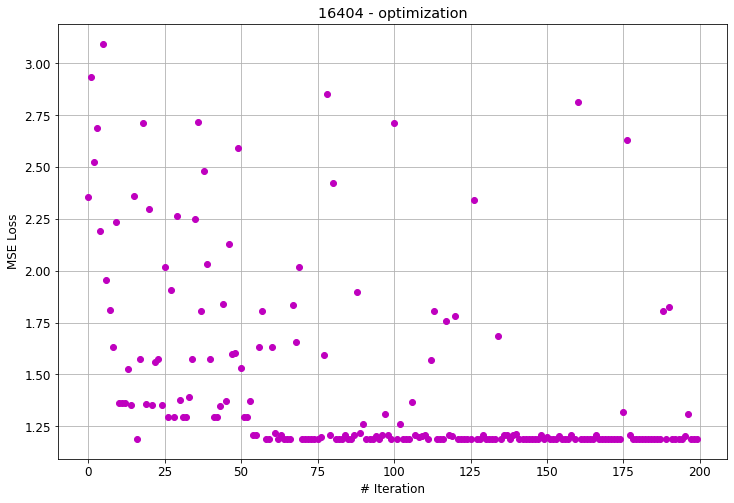

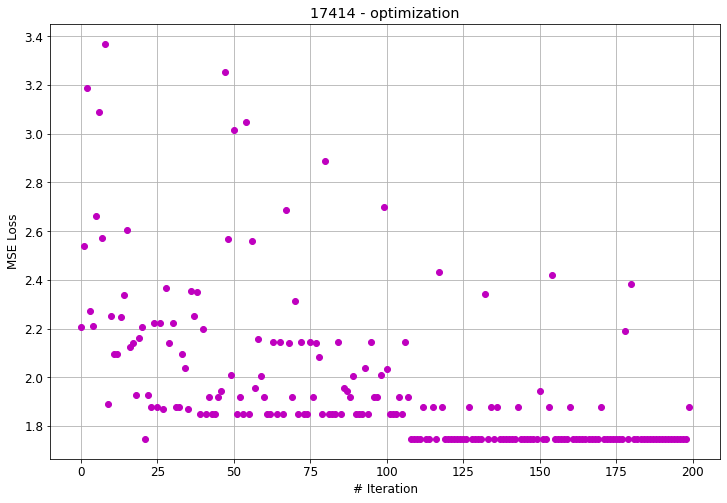

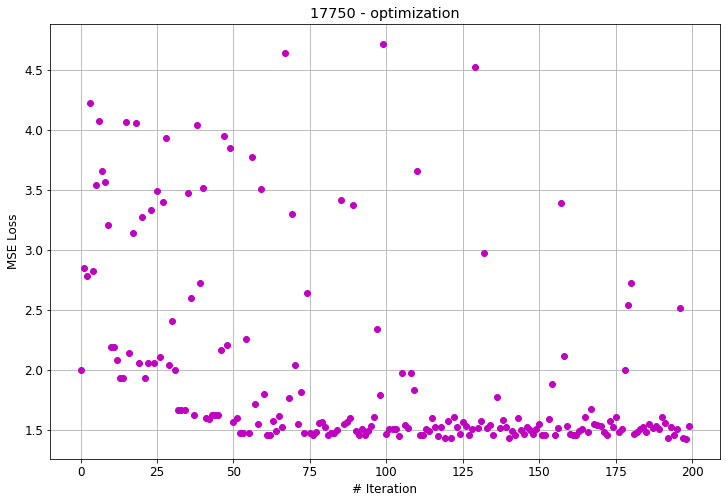

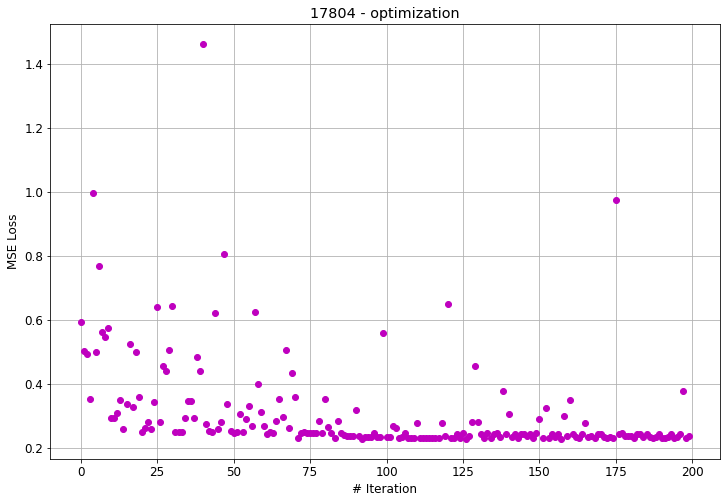

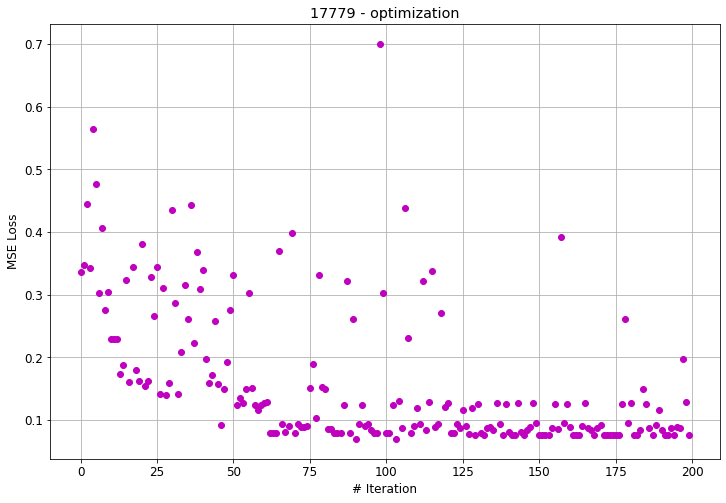

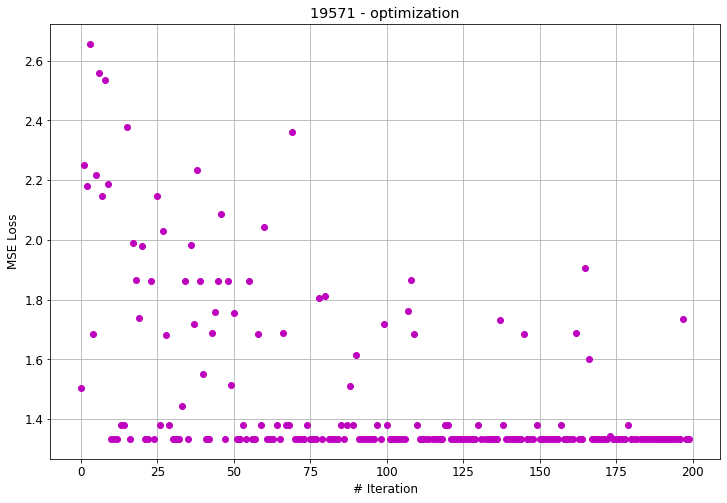

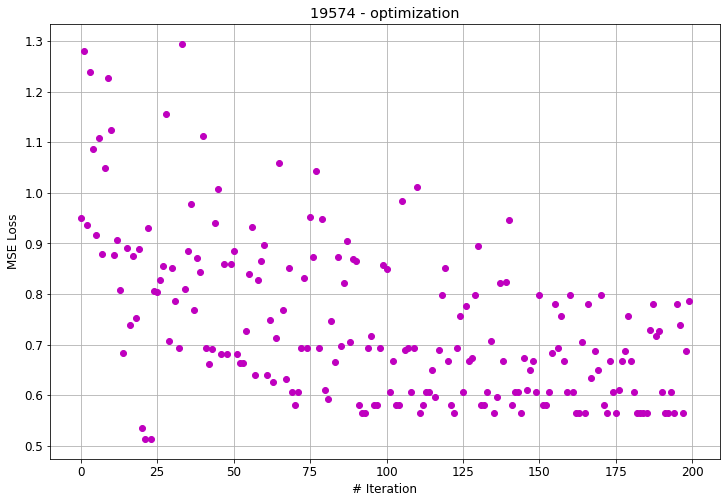

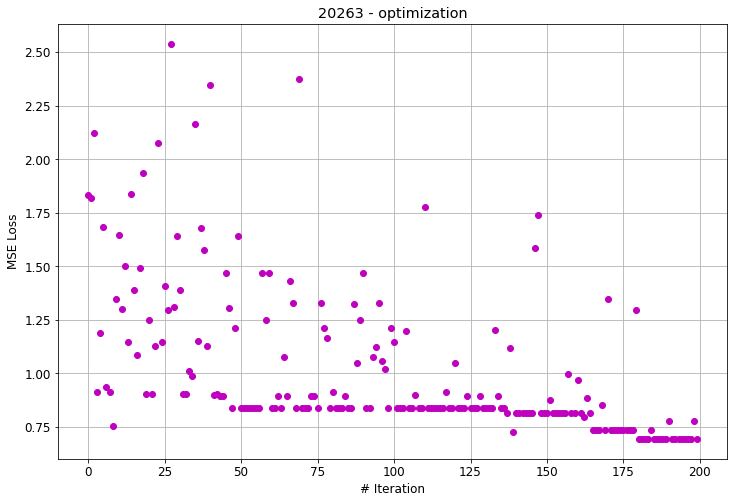

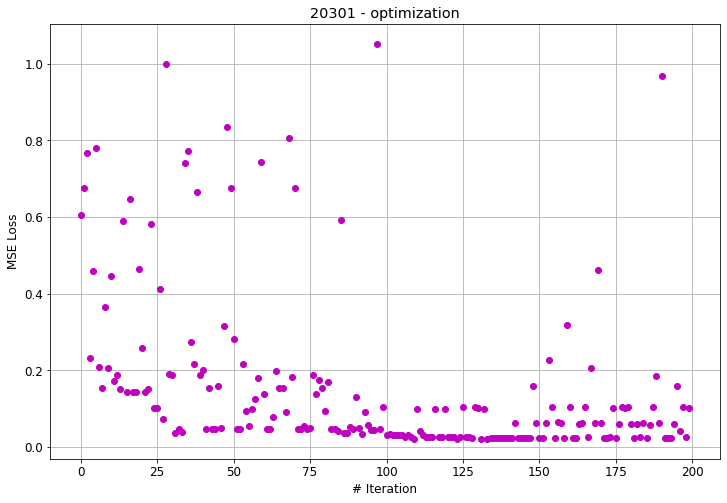

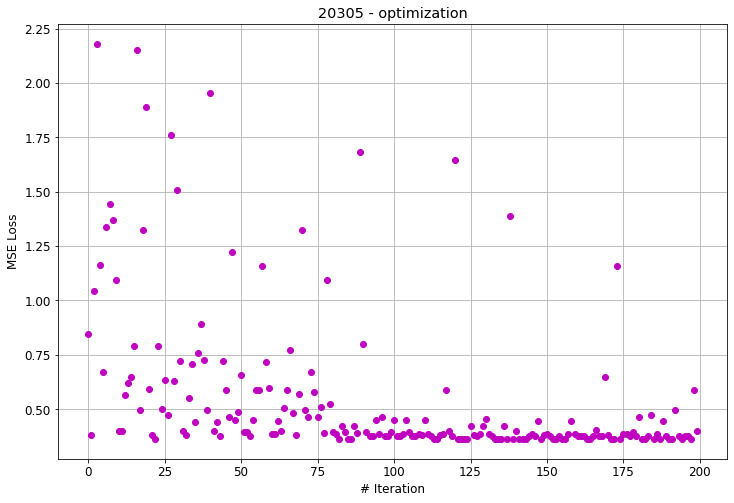

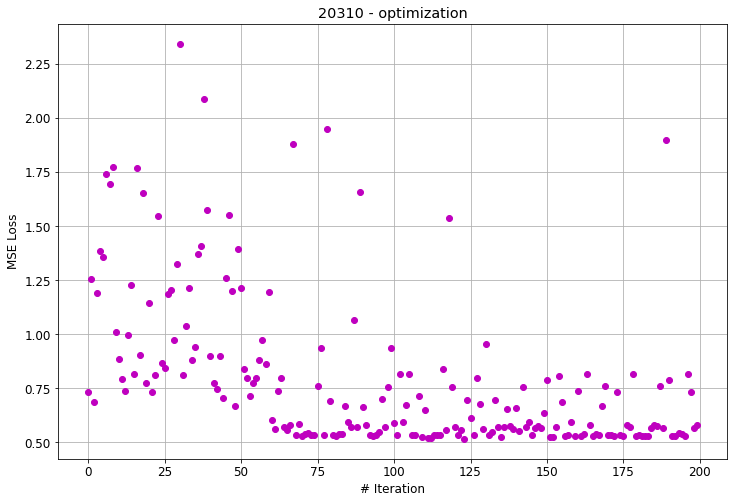

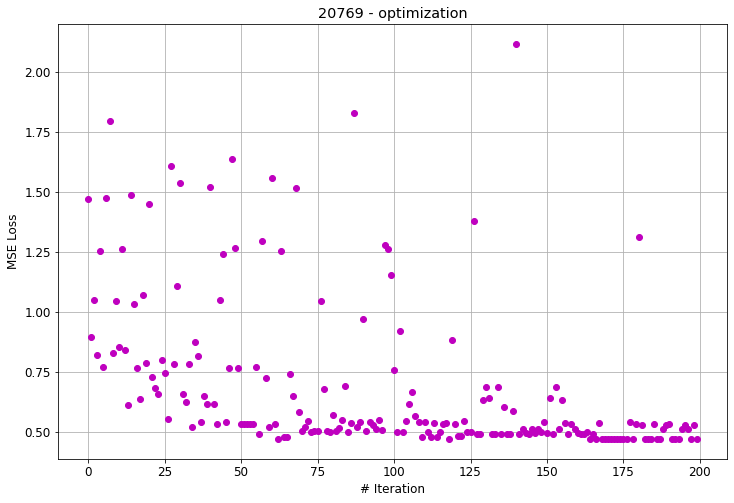

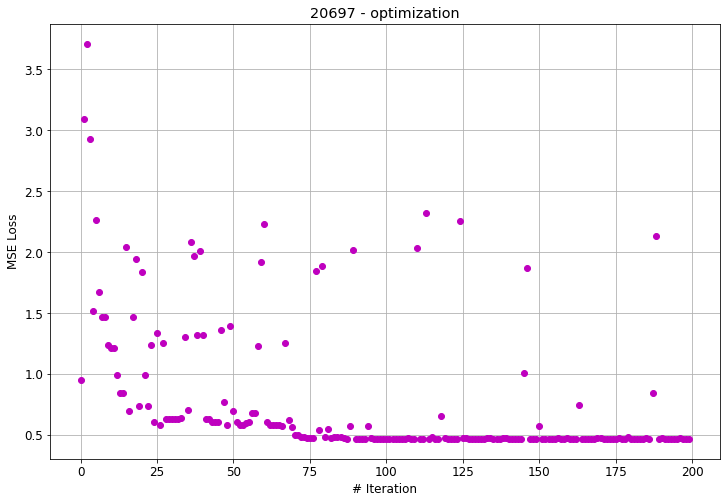

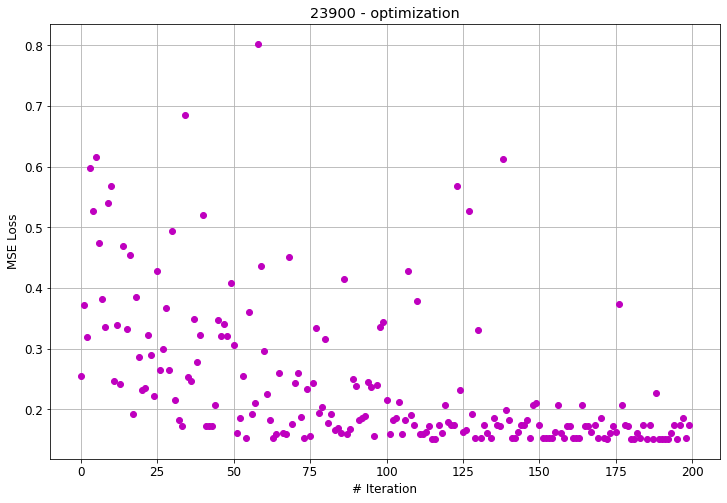

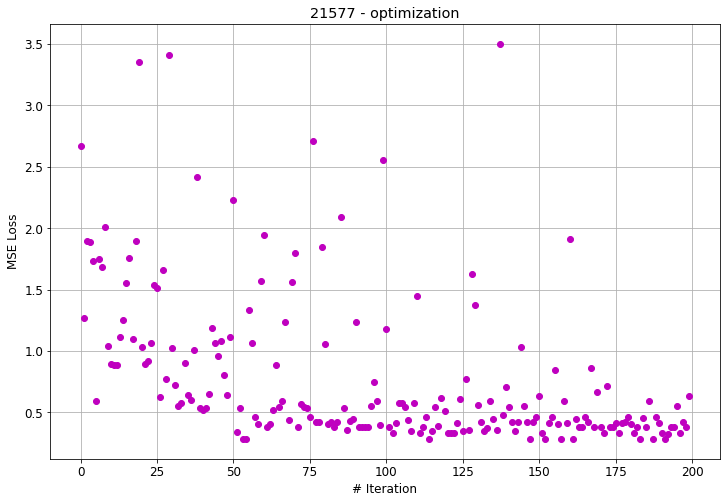

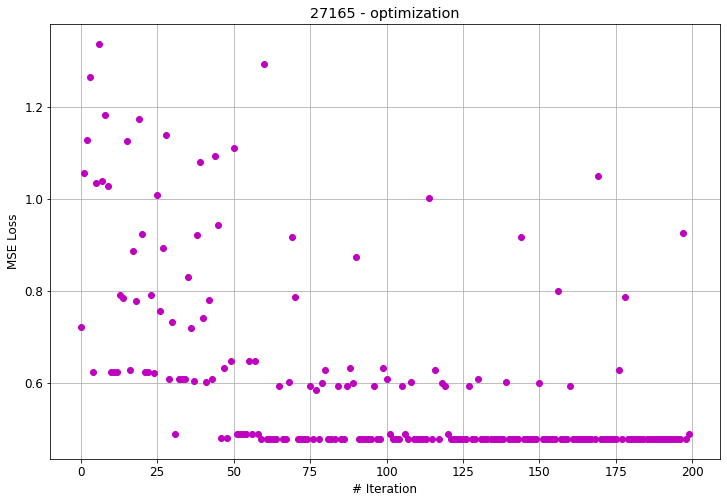

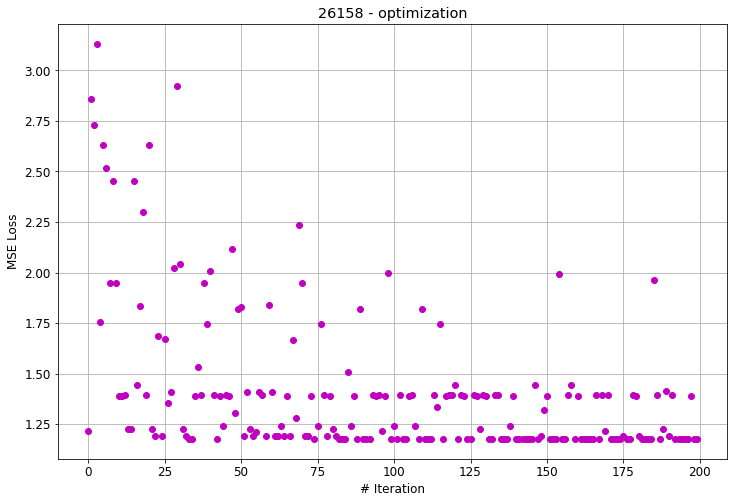

In [16]:
optimizer.print_optimizer_results()

In [15]:
optimizer.results.head()

,idArticulo,hyper,r2_test,mse_test,model
0,594.0,"{'n_lags': 3, 'max_depth': 4, 'random_state': ...",0.124297,1.999576,XGB
1,551.0,"{'n_lags': 2, 'max_depth': 6, 'random_state': ...",-0.125537,0.095949,XGB
2,963.0,"{'n_lags': 4, 'max_depth': 3, 'random_state': ...",-0.300556,1.327967,XGB
3,1208.0,"{'n_lags': 6, 'max_depth': 3, 'random_state': ...",-0.898656,0.114811,XGB
4,1627.0,"{'n_lags': 4, 'max_depth': 3, 'random_state': ...",-0.526941,1.046388,XGB
